In [1]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.4 MB 5.1 MB/s 
     |████████████████████████████████| 6.6 MB 8.9 MB/s 
     |████████████████████████████████| 596 kB 67.2 MB/s 
     |████████████████████████████████| 101 kB 12.8 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [2]:
# Use Huggingface (Pytorch) Framework
from transformers import AutoTokenizer, AutoModel
tokenizer = AutoTokenizer.from_pretrained("indolem/indobert-base-uncased")
model = AutoModel.from_pretrained("indolem/indobert-base-uncased")

Downloading:   0%|          | 0.00/42.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/0.99k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/229k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/424M [00:00<?, ?B/s]

Some weights of the model checkpoint at indolem/indobert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [49]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import os, sys

import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch import optim
import torch.nn.functional as F
from tqdm import tqdm

from transformers import BertForSequenceClassification, BertConfig, BertTokenizer
from nltk.tokenize import TweetTokenizer

from drive.MyDrive.Library.utils.forward_fn import forward_sequence_classification
from drive.MyDrive.Library.utils.metrics import document_sentiment_metrics_fn
from drive.MyDrive.Library.utils.data_utils import DocumentSentimentDataset,DocumentSentimentDataLoader

In [5]:
# Common Functions

# Set Random Seed
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

# Calculate The Total Number of Parameters
def count_param(module, trainable=False):
    if trainable:
        return sum(p.numel() for p in module.parameters() if p.requires_grad)
    else:
        return sum(p.numel() for p in module.parameters())

# Get Learning Rate During Training
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']


def metrics_to_string(metric_dict):
    string_list = []
    for key, value in metric_dict.items():
        string_list.append('{}:{:.2f}'.format(key, value))
    return ' '.join(string_list)

In [6]:
# Set Random Seed
set_seed(26092020)

Load Model

In [7]:
# Load Tokenizer and Config
tokenizer = BertTokenizer.from_pretrained('indobenchmark/indobert-base-p1')
config = BertConfig.from_pretrained('indobenchmark/indobert-base-p1')
config.num_labels = DocumentSentimentDataset.NUM_LABELS

# Instantiate model
model = BertForSequenceClassification.from_pretrained('indobenchmark/indobert-base-p1', config=config)

Downloading:   0%|          | 0.00/224k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.50k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/475M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Prepare Dataset

In [8]:
train_dataset_path = './drive/MyDrive/Library/smsa_doc-sentiment-prosa/train_saham_v2.tsv'
valid_dataset_path = './drive/MyDrive/Library/smsa_doc-sentiment-prosa/valid_saham.tsv'

Text(0, 0.5, '')

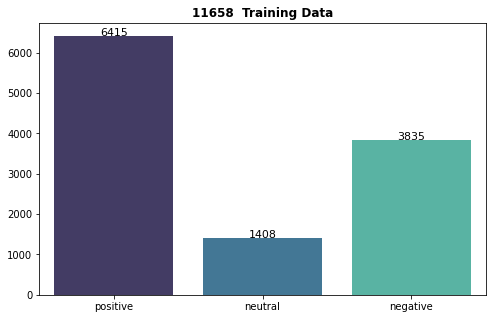

In [22]:
cplot = pd.read_csv(train_dataset_path, sep='\t')
cplot.columns = ['content_original', 'label']

countplt, ax = plt.subplots(figsize = (8,5))
ax = sns.countplot(data=cplot, x='label', palette='mako', order=['positive', 'neutral', 'negative'])
for rect in ax.patches:
    ax.text (rect.get_x() + rect.get_width()  / 2,rect.get_height()+ 0.75,rect.get_height(),horizontalalignment='center', fontsize = 11)
ax.set_title('11658  Training Data',fontsize = 12, fontweight='bold' )
ax.set_xlabel('')
ax.set_ylabel('')

Text(0, 0.5, '')

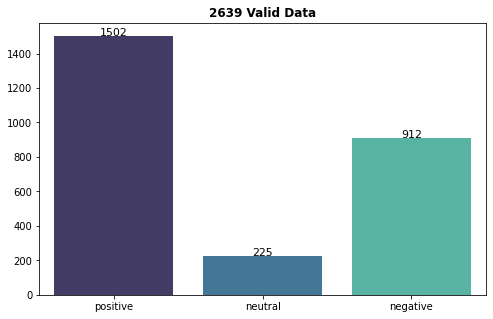

In [26]:
cplot = pd.read_csv(valid_dataset_path, sep='\t')
cplot.columns = ['content_original', 'label']

countplt, ax = plt.subplots(figsize = (8,5))
ax = sns.countplot(data=cplot, x='label', palette='mako', order=['positive', 'neutral', 'negative'])
for rect in ax.patches:
    ax.text (rect.get_x() + rect.get_width()  / 2,rect.get_height()+ 0.75,rect.get_height(),horizontalalignment='center', fontsize = 11)
ax.set_title('2639 Valid Data',fontsize = 12, fontweight='bold' )
ax.set_xlabel('')
ax.set_ylabel('')

In [27]:
train_dataset = DocumentSentimentDataset(train_dataset_path, tokenizer, lowercase=False)
valid_dataset = DocumentSentimentDataset(valid_dataset_path, tokenizer, lowercase=True)


train_loader = DocumentSentimentDataLoader(dataset=train_dataset, max_seq_len=512, batch_size=32, num_workers=16, shuffle=True)  
valid_loader = DocumentSentimentDataLoader(dataset=valid_dataset, max_seq_len=512, batch_size=32, num_workers=16, shuffle=False)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [28]:
w2i, i2w = DocumentSentimentDataset.LABEL2INDEX, DocumentSentimentDataset.INDEX2LABEL
print(w2i)
print(i2w)

{'positive': 0, 'neutral': 1, 'negative': 2}
{0: 'positive', 1: 'neutral', 2: 'negative'}


Test Model On Sample Sentences

In [29]:
text = 'enak sekali ya'
subwords = tokenizer.encode(text)
subwords = torch.LongTensor(subwords).view(1, -1).to(model.device)

logits = model(subwords)[0]
label = torch.topk(logits, k=1, dim=-1)[1].squeeze().item()

print(f'Text: {text} | Label : {i2w[label]} ({F.softmax(logits, dim=-1).squeeze()[label] * 100:.3f}%)')

Text: enak sekali ya | Label : positive (45.687%)


Fine Tuning & Evaluation

In [30]:
optimizer = optim.Adam(model.parameters(), lr=3e-6)
model = model.cuda()

In [ ]:
# Train
n_epochs = 10
for epoch in range(n_epochs):
    model.train()
    torch.set_grad_enabled(True)
 
    total_train_loss = 0
    list_hyp, list_label = [], []

    train_pbar = tqdm(train_loader, leave=True, total=len(train_loader))
    for i, batch_data in enumerate(train_pbar):
        # Forward model
        loss, batch_hyp, batch_label = forward_sequence_classification(model, batch_data[:-1], i2w=i2w, device='cuda')

        # Update model
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        tr_loss = loss.item()
        total_train_loss = total_train_loss + tr_loss

        # Calculate metrics
        list_hyp += batch_hyp
        list_label += batch_label

        train_pbar.set_description("(Epoch {}) TRAIN LOSS:{:.4f} LR:{:.8f}".format((epoch+1),
            total_train_loss/(i+1), get_lr(optimizer)))

    # Calculate train metric
    metrics = document_sentiment_metrics_fn(list_hyp, list_label)
    print("(Epoch {}) TRAIN LOSS:{:.4f} {} LR:{:.8f}".format((epoch+1),
        total_train_loss/(i+1), metrics_to_string(metrics), get_lr(optimizer)))

    # Evaluate on validation
    model.eval()
    torch.set_grad_enabled(False)
    
    total_loss, total_correct, total_labels = 0, 0, 0
    list_hyp, list_label = [], []

    pbar = tqdm(valid_loader, leave=True, total=len(valid_loader))
    for i, batch_data in enumerate(pbar):
        batch_seq = batch_data[-1]        
        loss, batch_hyp, batch_label = forward_sequence_classification(model, batch_data[:-1], i2w=i2w, device='cuda')
        
        # Calculate total loss
        valid_loss = loss.item()
        total_loss = total_loss + valid_loss

        # Calculate evaluation metrics
        list_hyp += batch_hyp
        list_label += batch_label
        metrics = document_sentiment_metrics_fn(list_hyp, list_label)

        pbar.set_description("VALID LOSS:{:.4f} {}".format(total_loss/(i+1), metrics_to_string(metrics)))
        
    metrics = document_sentiment_metrics_fn(list_hyp, list_label)
    print("(Epoch {}) VALID LOSS:{:.4f} {}".format((epoch+1),
        total_loss/(i+1), metrics_to_string(metrics)))

  0%|          | 0/365 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
(Epoch 1) TRAIN LOSS:0.4616 LR:0.00000300: 100%|██████████| 365/365 [02:58<00:00,  2.05it/s]


(Epoch 1) TRAIN LOSS:0.4616 ACC:0.81 F1:0.74 REC:0.72 PRE:0.78 LR:0.00000300


  0%|          | 0/83 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
VALID LOSS:0.2268 ACC:0.92 F1:0.88 REC:0.87 PRE:0.90: 100%|██████████| 83/83 [00:17<00:00,  4.64it/s]


(Epoch 1) VALID LOSS:0.2268 ACC:0.92 F1:0.88 REC:0.87 PRE:0.90


  0%|          | 0/365 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
(Epoch 2) TRAIN LOSS:0.2634 LR:0.00000300: 100%|██████████| 365/365 [03:04<00:00,  1.98it/s]


(Epoch 2) TRAIN LOSS:0.2634 ACC:0.90 F1:0.87 REC:0.87 PRE:0.87 LR:0.00000300


  0%|          | 0/83 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
VALID LOSS:0.2156 ACC:0.92 F1:0.89 REC:0.87 PRE:0.92: 100%|██████████| 83/83 [00:16<00:00,  4.92it/s]


(Epoch 2) VALID LOSS:0.2156 ACC:0.92 F1:0.89 REC:0.87 PRE:0.92


  0%|          | 0/365 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
(Epoch 3) TRAIN LOSS:0.2089 LR:0.00000300: 100%|██████████| 365/365 [03:02<00:00,  2.00it/s]


(Epoch 3) TRAIN LOSS:0.2089 ACC:0.92 F1:0.90 REC:0.90 PRE:0.90 LR:0.00000300


  0%|          | 0/83 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
VALID LOSS:0.2020 ACC:0.93 F1:0.91 REC:0.91 PRE:0.91: 100%|██████████| 83/83 [00:17<00:00,  4.88it/s]


(Epoch 3) VALID LOSS:0.2020 ACC:0.93 F1:0.91 REC:0.91 PRE:0.91


  0%|          | 0/365 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
(Epoch 4) TRAIN LOSS:0.1640 LR:0.00000300: 100%|██████████| 365/365 [03:03<00:00,  1.99it/s]


(Epoch 4) TRAIN LOSS:0.1640 ACC:0.94 F1:0.92 REC:0.93 PRE:0.92 LR:0.00000300


  0%|          | 0/83 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
VALID LOSS:0.2030 ACC:0.93 F1:0.90 REC:0.89 PRE:0.92: 100%|██████████| 83/83 [00:16<00:00,  4.89it/s]


(Epoch 4) VALID LOSS:0.2030 ACC:0.93 F1:0.90 REC:0.89 PRE:0.92


  0%|          | 0/365 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
(Epoch 5) TRAIN LOSS:0.1255 LR:0.00000300: 100%|██████████| 365/365 [03:03<00:00,  1.99it/s]


(Epoch 5) TRAIN LOSS:0.1255 ACC:0.96 F1:0.94 REC:0.94 PRE:0.94 LR:0.00000300


  0%|          | 0/83 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
VALID LOSS:0.2198 ACC:0.93 F1:0.90 REC:0.89 PRE:0.92: 100%|██████████| 83/83 [00:16<00:00,  4.90it/s]


(Epoch 5) VALID LOSS:0.2198 ACC:0.93 F1:0.90 REC:0.89 PRE:0.92


  0%|          | 0/365 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
(Epoch 6) TRAIN LOSS:0.0970 LR:0.00000300: 100%|██████████| 365/365 [03:03<00:00,  1.99it/s]


(Epoch 6) TRAIN LOSS:0.0970 ACC:0.97 F1:0.96 REC:0.96 PRE:0.96 LR:0.00000300


  0%|          | 0/83 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
VALID LOSS:0.2471 ACC:0.93 F1:0.91 REC:0.89 PRE:0.94: 100%|██████████| 83/83 [00:17<00:00,  4.86it/s]


(Epoch 6) VALID LOSS:0.2471 ACC:0.93 F1:0.91 REC:0.89 PRE:0.94


  0%|          | 0/365 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
(Epoch 7) TRAIN LOSS:0.0679 LR:0.00000300: 100%|██████████| 365/365 [03:04<00:00,  1.97it/s]


(Epoch 7) TRAIN LOSS:0.0679 ACC:0.98 F1:0.97 REC:0.97 PRE:0.97 LR:0.00000300


  0%|          | 0/83 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
VALID LOSS:0.2673 ACC:0.93 F1:0.91 REC:0.90 PRE:0.91: 100%|██████████| 83/83 [00:16<00:00,  4.89it/s]


(Epoch 7) VALID LOSS:0.2673 ACC:0.93 F1:0.91 REC:0.90 PRE:0.91


  0%|          | 0/365 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
(Epoch 8) TRAIN LOSS:0.0518 LR:0.00000300: 100%|██████████| 365/365 [03:04<00:00,  1.98it/s]


(Epoch 8) TRAIN LOSS:0.0518 ACC:0.98 F1:0.98 REC:0.98 PRE:0.98 LR:0.00000300


  0%|          | 0/83 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
VALID LOSS:0.3062 ACC:0.92 F1:0.90 REC:0.87 PRE:0.93: 100%|██████████| 83/83 [00:17<00:00,  4.86it/s]


(Epoch 8) VALID LOSS:0.3062 ACC:0.92 F1:0.90 REC:0.87 PRE:0.93


  0%|          | 0/365 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
(Epoch 9) TRAIN LOSS:0.0391 LR:0.00000300: 100%|██████████| 365/365 [03:03<00:00,  1.99it/s]


(Epoch 9) TRAIN LOSS:0.0391 ACC:0.99 F1:0.98 REC:0.98 PRE:0.98 LR:0.00000300


  0%|          | 0/83 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
VALID LOSS:0.3035 ACC:0.93 F1:0.91 REC:0.89 PRE:0.93: 100%|██████████| 83/83 [00:17<00:00,  4.88it/s]


(Epoch 9) VALID LOSS:0.3035 ACC:0.93 F1:0.91 REC:0.89 PRE:0.93


  0%|          | 0/365 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
(Epoch 10) TRAIN LOSS:0.0307 LR:0.00000300: 100%|██████████| 365/365 [03:03<00:00,  1.98it/s]


(Epoch 10) TRAIN LOSS:0.0307 ACC:0.99 F1:0.99 REC:0.99 PRE:0.99 LR:0.00000300


  0%|          | 0/83 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
VALID LOSS:0.2990 ACC:0.93 F1:0.91 REC:0.89 PRE:0.93: 100%|██████████| 83/83 [00:17<00:00,  4.88it/s]

(Epoch 10) VALID LOSS:0.2990 ACC:0.93 F1:0.91 REC:0.89 PRE:0.93


In [ ]:
#torch.save(model,"drive/MyDrive/Colab Notebooks/model11NLP.pt")

In [54]:
myNLPmodel10 = torch.load("drive/MyDrive/Colab Notebooks/model11NLP.pt")

Test Fine-Tuned Model On Sample Sentences

In [55]:
text = 'FREN TURUN CUY'
subwords = tokenizer.encode(text)
subwords = torch.LongTensor(subwords).view(1, -1).to(myNLPmodel10.device)

logits = myNLPmodel10(subwords)[0]

label = torch.topk(logits, k=1, dim=-1)[1].squeeze().item()
print("Label Number :",label)
print(f'Text: {text} | Label : {i2w[label]} ({F.softmax(logits, dim=-1).squeeze()[label] * 100:.3f}%)')

Label Number : 2
Text: FREN TURUN CUY | Label : negative (99.521%)


In [56]:
text = 'FREN GOGO NAIK TERUS'
subwords = tokenizer.encode(text)
subwords = torch.LongTensor(subwords).view(1, -1).to(myNLPmodel10.device)

logits = myNLPmodel10(subwords)[0]
label = torch.topk(logits, k=1, dim=-1)[1].squeeze().item()
print("Label Number :",label)
print(f'Label : {i2w[label]} ({F.softmax(logits, dim=-1).squeeze()[label] * 100:.3f}%)')

Label Number : 0
Label : positive (99.785%)


In [57]:
text = 'BUDI KE STOCKBIT MEMANTAU SAHAM'
subwords = tokenizer.encode(text)
subwords = torch.LongTensor(subwords).view(1, -1).to(myNLPmodel10.device)

logits = myNLPmodel10(subwords)[0]
label = torch.topk(logits, k=1, dim=-1)[1].squeeze().item()
print("Label Number :",label)
print(f'Label : {i2w[label]} ({F.softmax(logits, dim=-1).squeeze()[label] * 100:.3f}%)')

Label Number : 1
Label : neutral (99.902%)


In [58]:
%ls ./drive/MyDrive/Library/CS-3k/BJTM_comment_manual.xlsx
%ls ./drive/MyDrive/Library/CS-3k/antm_comment_manual.xlsx
%ls ./drive/MyDrive/Library/CS-3k/bris_comment_manual.xlsx

./drive/MyDrive/Library/CS-3k/BJTM_comment_manual.xlsx
./drive/MyDrive/Library/CS-3k/antm_comment_manual.xlsx
./drive/MyDrive/Library/CS-3k/bris_comment_manual.xlsx


In [31]:
testing_manual = pd.read_excel('./drive/MyDrive/Library/CS-3k/BJTM_comment_manual.xlsx')
testing_manual2 = pd.read_excel('./drive/MyDrive/Library/CS-3k/antm_comment_manual.xlsx')
testing_manual3 = pd.read_excel('./drive/MyDrive/Library/CS-3k/bris_comment_manual.xlsx')

testing_manual['manual'] = testing_manual['manual'].astype(int)
testing_manual

testing_manual2['manual'] = testing_manual2['manual'].astype(int)
testing_manual2

testing_manual3['manual'] = testing_manual3['manual'].astype(int)
testing_manual3

frames = [testing_manual, testing_manual2, testing_manual3]
testing_manual_final = pd.concat(frames)

selected_testing = testing_manual_final.filter(['content_original','created','likes','manual'], axis=1)
selected_testing.dropna(inplace=True)
selected_testing.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1289 entries, 0 to 435
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   content_original  1289 non-null   object 
 1   created           1289 non-null   object 
 2   likes             1289 non-null   float64
 3   manual            1289 non-null   int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 50.4+ KB


Text(0, 0.5, '')

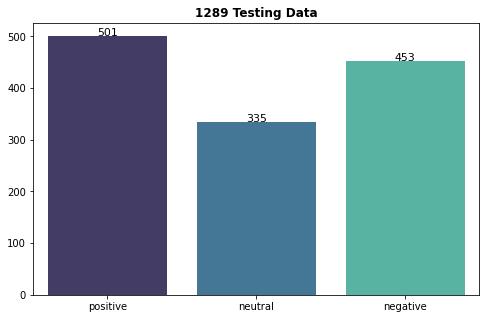

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns

cplot = selected_testing.copy()
cplot['manual'].replace({-1:'negative',1:'positive',0:'neutral'}, inplace=True)

countplt, ax = plt.subplots(figsize = (8,5))
ax = sns.countplot(data=cplot, x='manual', palette='mako', order=['positive', 'neutral', 'negative']) 
for rect in ax.patches:
    ax.text (rect.get_x() + rect.get_width()  / 2,rect.get_height()+ 0.75,rect.get_height(),horizontalalignment='center', fontsize = 11)
ax.set_title('1289 Testing Data',fontsize = 12, fontweight='bold' )
ax.set_xlabel('')
ax.set_ylabel('')

In [35]:
import re, string, timeit

s = "string. With. Punctuation"
s.translate(str.maketrans('', '', string.punctuation))
s

'string. With. Punctuation'

In [59]:
def check_sent(comments):
  subwords = tokenizer.encode(comments, truncation=True, max_length=512)
  subwords = torch.LongTensor(subwords).view(1, -1).to(myNLPmodel10.device)

  logits = myNLPmodel10(subwords)[0]
  label = torch.topk(logits, k=1, dim=-1)[1].squeeze().item()

  if label == 1 : 
    return 0
  elif label == 2 :
    return -1
  else :
    return 1

selected_testing['label_by_model'] = selected_testing['content_original'].apply(check_sent)
selected_testing.head()

,content_original,created,likes,manual,label_by_model
0,termasuk emiten anti badai retail lokal jangan...,2021-03-05 10:47:02,1.0,1,1
1,siap siap pasang bid ada diskon ini bursa Amer...,2021-03-05 07:37:42,1.0,-1,1
2,Kutunggu Dividen Mu,2021-03-04 19:27:42,3.0,0,1
3,Asal mindsetnya investor harga saham pasti sta...,2021-03-04 16:37:48,1.0,1,1
4,BOLA kena goreng pisang ciyah aja cuma bertaha...,2021-03-04 16:00:36,1.0,-1,-1


In [60]:
newArr = []
dataBenar = 0;
dataSalah = 0;
total = 0;
for index, row2 in selected_testing.iterrows():
    if total < 1600:
       total += 1;
    if row2['label_by_model'] != row2['manual']:
      dataSalah += 1;
    else :
      dataBenar += 1;

print(dataBenar/total)

0.6035686578743211


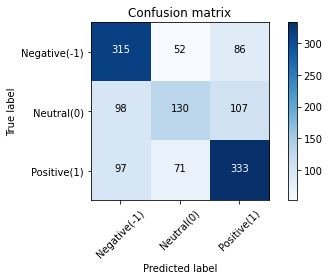

In [61]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range (cm.shape[0]):
      for j in range (cm.shape[1]):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(selected_testing['manual'], selected_testing['label_by_model'])
plt.figure()
plot_confusion_matrix(cm, classes=['Negative(-1)','Neutral(0)','Positive(1)'],
                      title='Confusion matrix')

In [64]:
from sklearn.metrics import classification_report
print(classification_report(selected_testing['manual'], selected_testing['label_by_model']))

              precision    recall  f1-score   support

          -1       0.62      0.70      0.65       453
           0       0.51      0.39      0.44       335
           1       0.63      0.66      0.65       501

    accuracy                           0.60      1289
   macro avg       0.59      0.58      0.58      1289
weighted avg       0.60      0.60      0.60      1289

